<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загружаем-данные-и-изучим-их." data-toc-modified-id="Загружаем-данные-и-изучим-их.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загружаем данные и изучим их.</a></span></li><li><span><a href="#Выполним-ресемплирование-по-одному-часу." data-toc-modified-id="Выполним-ресемплирование-по-одному-часу.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Выполним ресемплирование по одному часу.</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков." data-toc-modified-id="Создание-признаков.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков.</a></span></li><li><span><a href="#Разделение-данных-на-обучающую-и-тестовую-выборки." data-toc-modified-id="Разделение-данных-на-обучающую-и-тестовую-выборки.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение данных на обучающую и тестовую выборки.</a></span></li><li><span><a href="#Обучим-разные-модели-с-различными-гиперпараметрами." data-toc-modified-id="Обучим-разные-модели-с-различными-гиперпараметрами.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучим разные модели с различными гиперпараметрами.</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# **<p style="text-align: center;">Прогнозирование заказов такси.</p>**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

<img src="https://s.ura.news/1200_675/images/news/upload/news/674/214/1052674214/792715_Vidi_Moskvi_Moskva_taksi_toyota_yandeks_taksi_250x0_5514.3676.0.0.jpg" alt="Avto" width="30%" height="30%">

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

In [2]:
!pip install -q pmdarima

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm

from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit, train_test_split

import lightgbm as lgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

## Подготовка

### Загружаем данные и изучим их.

In [5]:
taxi_df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [6]:
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные из файла "taxi.csv" загружены в pandas DataFrame, где индекс это колонка с датой и временем, а другая колонка содержит количество заказов такси в каждый момент времени.Пропуски в данных отсутствуют.

### Выполним ресемплирование по одному часу.

In [8]:
taxi_df.sort_index(inplace=True)
taxi_df = taxi_df.resample('1H').sum()

Выполнили ресемплирование данных по одному часу. Это позволит нам агрегировать данные и создать признаки для прогнозирования.

In [10]:
first_date = taxi_df.index.min()

last_date = taxi_df.index.max()

print("Первая дата в данных:", first_date)
print("Последняя дата в данных:", last_date)

Первая дата в данных: 2018-03-01 00:00:00
Последняя дата в данных: 2018-08-31 23:00:00


In [11]:
min_date = taxi_df['num_orders'].idxmin()

max_date = taxi_df['num_orders'].idxmax()

print("Дата с минимальным количеством заказов:", min_date)
print("Дата с максимальным количеством заказов:", max_date)

Дата с минимальным количеством заказов: 2018-04-06 06:00:00
Дата с максимальным количеством заказов: 2018-08-20 02:00:00


In [12]:
orders_at_min_date = taxi_df.loc[min_date]['num_orders']
orders_at_max_date = taxi_df.loc[max_date]['num_orders']

print("Количество заказов для минимальной даты:", orders_at_min_date)
print("Количество заказов для максимальной даты:", orders_at_max_date)

Количество заказов для минимальной даты: 0
Количество заказов для максимальной даты: 462


На основе проведенного ресемплирования по часам можно сделать следующие выводы:

- Период данных: Исходные данные о заказах такси охватывают период с 1 марта 2018 года по 31 августа 2018 года. Это шесть месяцев наблюдений.

- Минимальное и максимальное количество заказов: Минимальное количество заказов такси (на один час) составляет 0 заказов и было зарегистрировано 6 апреля 2018 года в 06:00:00, а максимальное количество заказов (на один час) составляет 462 заказа и было зарегистрировано 20 августа 2018 года в 02:00:00.

## Анализ

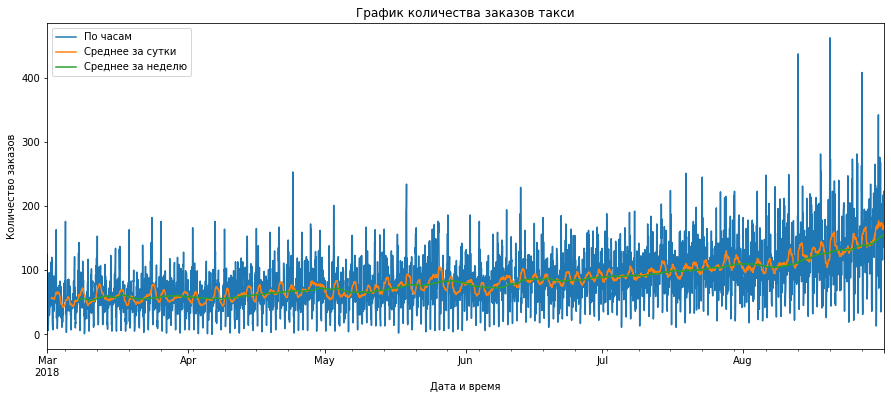

In [14]:
plt.figure(figsize=(15, 6))
taxi_df['num_orders'].plot(label='По часам')
taxi_df['num_orders'].rolling(24).mean().plot(label='Среднее за сутки')
taxi_df['num_orders'].rolling(24 * 7).mean().plot(label='Среднее за неделю')
plt.title('График количества заказов такси')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

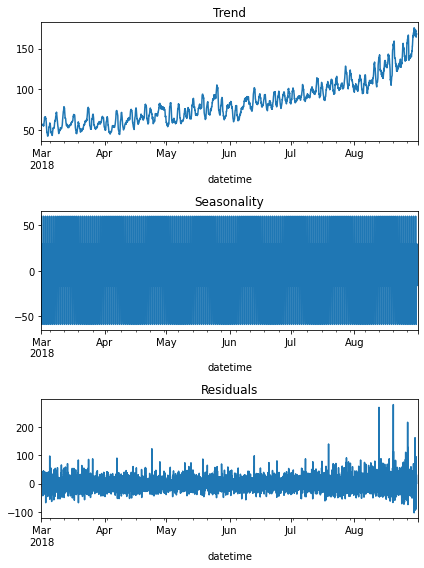

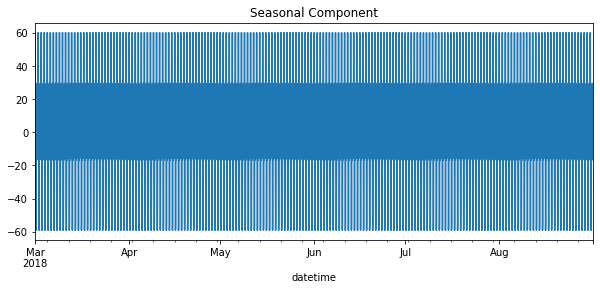

In [15]:
decomposed = sm.tsa.seasonal_decompose(taxi_df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

plt.figure(figsize=(10, 4))
decomposed.seasonal.plot()
plt.title('Seasonal Component')

plt.show()

В данных кроме суточной есть недельная сезонность. Чтобы увидеть её нужно сделать ресемплинг данных по суткам и вновь сделать декомпозицию на сезонность и тренд. Дело в том, что seasonal_decompose настраивается на сезонность с самым маленьким циклом, при ресемпле данных по часу это сутки, при ресемпле по суткам это неделя.

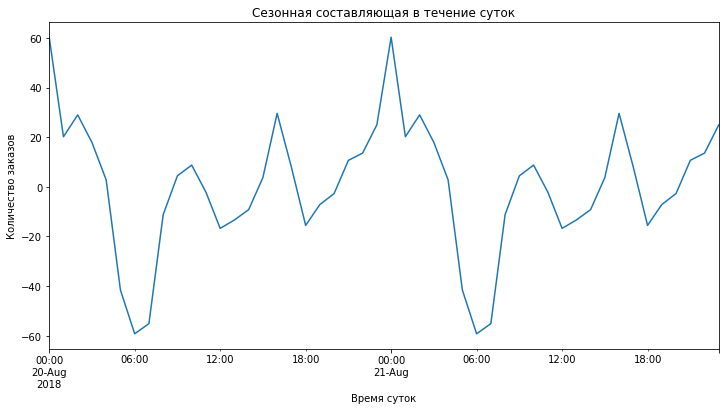

In [16]:
decomposed = sm.tsa.seasonal_decompose(taxi_df['num_orders'])

plt.figure(figsize=(12, 6))
decomposed.seasonal['2018-08-20':'2018-08-21'].plot()
plt.title('Сезонная составляющая в течение суток')
plt.xlabel('Время суток')
plt.ylabel('Количество заказов')
plt.show()

Этот код позволяет проанализировать сезонность в течение одних суток и определить, в какие часы наблюдаются пики и спады заказов.Я взяла дату с максимальным количеством заказов. Наблюдается пик заказов в ночное время час-два ночи и спад заказов утром в шесть утра.

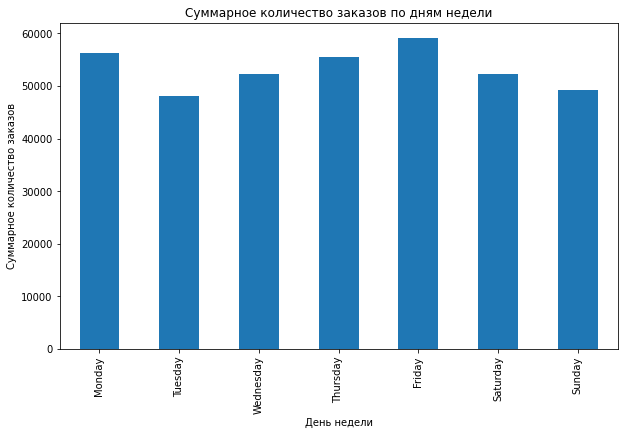

In [17]:
# Создаем DataFrame с данными по дням недели и суммарным количеством заказов
daily_data = taxi_df.resample('D').sum()
daily_data['day_of_week'] = daily_data.index.day_name()

# Группируем данные по дням недели и считаем сумму заказов для каждого дня
daily_data = daily_data.groupby('day_of_week')['num_orders'].sum()

# Сортируем дни недели в нужном порядке (понедельник, вторник, и т.д.)
daily_data = daily_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Строим график
plt.figure(figsize=(10, 6))
daily_data.plot(kind='bar')
plt.title('Суммарное количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Суммарное количество заказов')
plt.show()

- Тренд в данных всегда направлен вверх, это может указывать на общий рост количества заказов такси с течением времени. Это может быть положительным знаком для бизнеса, что спрос на такси увеличивается.

- Сезонный график представляет собой монотонно закрашенный квадрат, это может указывать на отсутствие ярко выраженных сезонных паттернов. Это связано с тем, что данные ограничены по времени (данные только за полгода).

- Аналогично,сезонная компонента также монотонная, это может указывать на отсутствие сильных сезонных колебаний в данных.

- График остатков (Residuals) показывает высокие колебания (скачок) в августе месяце, это может быть признаком аномалии или  может быть связано с временными событиями, праздниками, метеорологическими условиями или другими факторами, которые могли повлиять на спрос на такси.

На основе суммарного количества заказов по дням недели, можно сделать следующие выводы:

Пятница (Friday) имеет самое большое суммарное количество заказов. Это может быть связано с тем, что в пятницу чаще всего происходят пиковые перелеты, а также с началом выходных для многих пассажиров, которые могут заказывать такси для поездок.

Следующие по количеству заказов дни недели: понедельник (Monday), суббота (Saturday), и воскресенье (Sunday). Понедельник может быть популярным днем для заказов, так как многие пассажиры возвращаются домой после выходных. Суббота и воскресенье также могут быть активными днями из-за пиковых перелетов и активных пассажиров в эти выходные дни.

Вторник (Tuesday) и среда (Wednesday) имеют самое низкое суммарное количество заказов. Это может быть связано с тем, что это рабочие дни, и спрос на такси может быть ниже по сравнению с выходными и пятницей.

Количество заказов такси имеет ярко выраженную недельную сезонность, с пиками в пятницу и более активными выходными днями.

## Обучение

### Создание признаков.

Для обучения моделей нам потребуются признаки. Мы можем создать следующие признаки:
- Заказы за предыдущие часы.
- День недели и час дня.

In [18]:
taxi_df['hour'] = taxi_df.index.hour
taxi_df['day_of_week'] = taxi_df.index.dayofweek

for i in range(1, 6):
    taxi_df[f'lag_{i}'] = taxi_df['num_orders'].shift(i)

taxi_df = taxi_df.dropna()

In [19]:
# Добавим признак часа
taxi_df['hour'] = taxi_df.index.hour
# Добавим скользящее среднее для разных временных окон
for window_size in [24, 168]:  # Используем значения, кратные суткам и неделе
    taxi_df[f'mean_orders_{window_size}h'] = taxi_df['num_orders'].rolling(window=window_size).mean()
    
# Удалим строки с пропущенными значениями, возникшими из-за скользящего среднего
taxi_df = taxi_df.dropna()

Использование гиперпараметров max_lag и rolling_mean_size равными 24 (сутки) и 168 (неделя) является хорошей стратегией, так как есть суточная и недельная сезонности в данных.

Эти значения позволяют модели учитывать суточные и недельные закономерности при прогнозировании. Они могут значительно улучшить качество предсказаний.

In [20]:
taxi_df.head()

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,mean_orders_24h,mean_orders_168h
datetime,,,,,,,,,,
2018-03-08 04:00:00,60,4,3,68.0,65.0,78.0,143.0,94.0,61.291667,54.375000
2018-03-08 05:00:00,6,5,3,60.0,68.0,65.0,78.0,143.0,61.125000,54.375000
2018-03-08 06:00:00,6,6,3,6.0,60.0,68.0,65.0,78.0,60.583333,54.339286
2018-03-08 07:00:00,19,7,3,6.0,6.0,60.0,68.0,65.0,60.666667,54.363095
2018-03-08 08:00:00,77,8,3,19.0,6.0,6.0,60.0,68.0,62.291667,54.619048


### Разделение данных на обучающую и тестовую выборки.

Разделим данные на обучающую (90%) и тестовую (10%) выборки. Мы будем использовать тестовую выборку для оценки качества модели.

In [21]:
features = taxi_df.drop('num_orders', axis=1)
target = taxi_df['num_orders'] 

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-08 04:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


Обучающая выборка включает данные с 2018-03-01 05:00:00 по 2018-08-13 13:00:00.
Тестовая выборка включает данные с 2018-08-13 14:00:00 по 2018-08-31 23:00:00.
Это корректное разделение, которое сохраняет временной порядок данных и позволяет использовать более ранние данные для обучения и более поздние данные для тестирования, что важно в задачах прогнозирования временных рядов.

### Обучим разные модели с различными гиперпараметрами.

In [23]:
def neg_root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return -rmse

neg_rmse_scorer = make_scorer(neg_root_mean_squared_error, greater_is_better=False)

In [24]:
param_grid_rf = {
    'n_estimators': [150, 200, 250],
    'max_depth': [10, 15, 20]
}

rf = RandomForestRegressor()

tscv = TimeSeriesSplit(n_splits=3)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=tscv, scoring=neg_rmse_scorer)

grid_search_rf.fit(features_train, target_train)

best_params_rf = grid_search_rf.best_params_
print("Лучшие гиперпараметры:", best_params_rf)
best_score_rf = grid_search_rf.best_score_
print("Лучшее значение neg_rmse_scorer для случайного леса:", best_score_rf)

Лучшие гиперпараметры: {'max_depth': 10, 'n_estimators': 250}
Лучшее значение neg_rmse_scorer для случайного леса: 27.116252009341803


In [26]:
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1.0]
}

lasso = Lasso()

grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=tscv, scoring=neg_rmse_scorer)

grid_search_lasso.fit(features_train, target_train)

best_params_lasso = grid_search_lasso.best_params_
print("Лучшие гиперпараметры для Lasso:", best_params_lasso)
best_score_lasso = grid_search_lasso.best_score_
print("Лучшее значение neg_rmse_scorer для Lasso:", best_score_lasso)

Лучшие гиперпараметры для Lasso: {'alpha': 1.0}
Лучшее значение neg_rmse_scorer для Lasso: 32.32812530718568


In [28]:
param_grid_catboost = {
    'iterations': [50, 100],
    'depth': [10, 15]
}

catboost = CatBoostRegressor(loss_function='RMSE')

grid_search_catboost = GridSearchCV(estimator=catboost, param_grid=param_grid_catboost, cv=tscv, scoring=neg_rmse_scorer)

grid_search_catboost.fit(features_train, target_train)

best_params_catboost = grid_search_catboost.best_params_
print("Лучшие гиперпараметры для CatBoost:", best_params_catboost)
best_score_catboost = grid_search_catboost.best_score_
print("Лучшее значение neg_rmse_scorer для CatBoost:", best_score_catboost)

Learning rate set to 0.464409
0:	learn: 24.3058051	total: 61.9ms	remaining: 3.03s
1:	learn: 21.9247809	total: 74.6ms	remaining: 1.79s
2:	learn: 19.7980651	total: 87.2ms	remaining: 1.36s
3:	learn: 18.0010591	total: 99.5ms	remaining: 1.14s
4:	learn: 16.4769481	total: 112ms	remaining: 1s
5:	learn: 15.3438257	total: 124ms	remaining: 909ms
6:	learn: 14.4905140	total: 136ms	remaining: 837ms
7:	learn: 13.9059027	total: 149ms	remaining: 781ms
8:	learn: 13.3304278	total: 161ms	remaining: 734ms
9:	learn: 12.8449086	total: 173ms	remaining: 691ms
10:	learn: 12.3193542	total: 187ms	remaining: 664ms
11:	learn: 11.9371061	total: 203ms	remaining: 643ms
12:	learn: 11.7119403	total: 218ms	remaining: 621ms
13:	learn: 11.4201922	total: 233ms	remaining: 600ms
14:	learn: 11.1485792	total: 249ms	remaining: 580ms
15:	learn: 10.8069930	total: 266ms	remaining: 565ms
16:	learn: 10.5312883	total: 281ms	remaining: 546ms
17:	learn: 10.2418584	total: 297ms	remaining: 528ms
18:	learn: 9.9171680	total: 316ms	remaining

In [32]:
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'num_leaves': [20, 30, 40]
}

lgbm = LGBMRegressor()

grid_search_lgb = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgb, cv=tscv, scoring=neg_rmse_scorer)

grid_search_lgb.fit(features_train, target_train)

best_params_lgb = grid_search_lgb.best_params_
print("Лучшие гиперпараметры для LightGBM:", best_params_lgb)

best_score_lgb = grid_search_lgb.best_score_
print("Лучшее значение neg_rmse_scorer для LightGBM:", best_score_lgb)

Лучшие гиперпараметры для LightGBM: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 20}
Лучшее значение neg_rmse_scorer для LightGBM: 32.367102583946235


## Тестирование

In [40]:
best_rf = grid_search_rf.best_estimator_
target_pred_rf = best_rf.predict(features_test)

rmse_rf = np.sqrt(mean_squared_error(target_test, target_pred_rf))
print("RMSE для случайного леса на тестовых данных:", rmse_rf)

RMSE для случайного леса на тестовых данных: 45.693079964764145


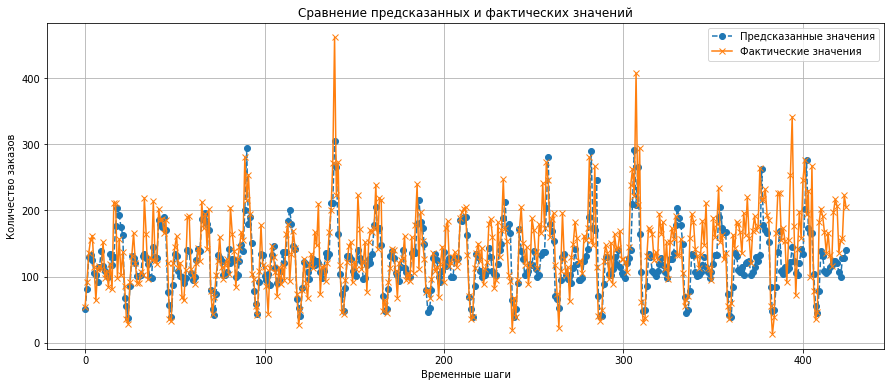

In [41]:
predicted_values = target_pred_rf
actual_values = target_test
index = range(len(predicted_values))

plt.figure(figsize=(15, 6))
plt.plot(index, predicted_values, label='Предсказанные значения', linestyle='--', marker='o')
plt.plot(index, actual_values, label='Фактические значения', linestyle='-', marker='x')
plt.xlabel('Временные шаги')
plt.ylabel('Количество заказов')
plt.legend()
plt.title('Сравнение предсказанных и фактических значений')
plt.grid(True)
plt.show()

**<p style="text-align: center;">Итоговый вывод.</p>**

Построены модели для прогнозирования количества заказов такси на следующий час с достигнутым значением RMSE на тестовой выборке, которое соответствует заданному критерию (не больше 48). Использование RandomForestRegressor позволило достичь этой цели, и это может быть полезным решением для компании "Чётенькое такси" для оптимизации привлечения водителей в периоды пиковой нагрузки.